# Cat Breed Classification with Keras VGG19


In [25]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    cat_files = np.array(data['filenames'])
    cat_targets = np_utils.to_categorical(np.array(data['target']), 134)
    return cat_files, cat_targets

train_files, train_targets = load_dataset('D:/Desktop/FYP/show-tell/static/CatIdentification/Train')
valid_files, valid_targets = load_dataset('D:/Desktop/FYP/show-tell/static/CatIdentification/Valid')
test_files, test_targets = load_dataset('D:/Desktop/FYP/show-tell/static/CatIdentification/Test')

cat_names = [item[20:-1] for item in sorted(glob("D:/Desktop/FYP/show-tell/static/CatIdentification/Train/*/"))]

# Let's check the dataset
print('There are %d total cat categories.' % len(cat_names))
print('There are %s total cat images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training cat images.' % len(train_files))
print('There are %d validation cat images.' % len(valid_files))
print('There are %d test cat images.'% len(test_files))

There are 9 total cat categories.
There are 1242 total cat images.

There are 693 training cat images.
There are 65 validation cat images.
There are 484 test cat images.


In [26]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImages(list_of_files, col=10, wSize=5, hSize=5, mypath='.'):
    fig = figure(figsize=(wSize, hSize))
    number_of_files = len(list_of_files)
    row = 10
    if (number_of_files % col != 0):
        row += 1
    for i in range(row+10):
        a=fig.add_subplot(row, col, i + 1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

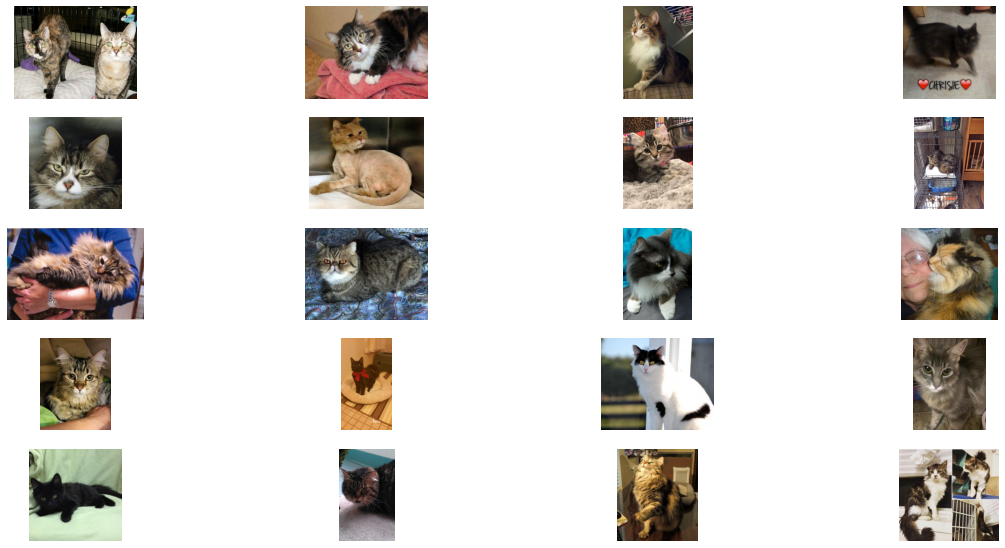

In [27]:
showImages(test_files, wSize=20, hSize=20, col=4)

In [28]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
## this function plot the breeds distribution 
def plot_breed(df):
    labels = []
    for i in range(df.shape[0]):
        labels.append(cat_names[np.argmax(df[i])])

    df_labels = pd.DataFrame(np.array(labels), columns=["breed"]).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(5,15))
    df_labels['breed'].value_counts().plot(ax=ax, kind='barh').invert_yaxis()
    ax.set_title('Distribution of Cat breeds')

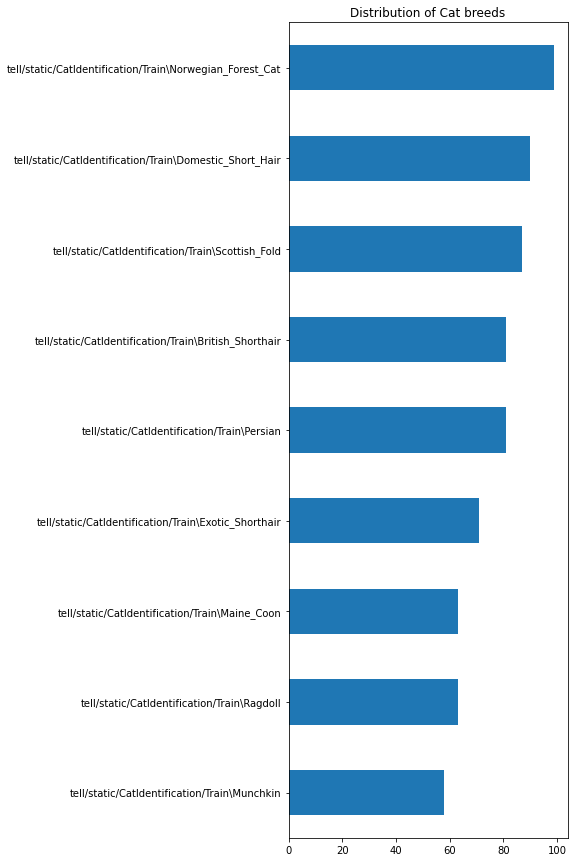

In [30]:
## breed distribution in train data
plot_breed(train_targets)

In [47]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

We rescale the images by dividing every pixel in every image by 255.

In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#### this function returns the shape of image, image itself and the  intensity distribution of an image
def img_hist(df_image, label):
    img = cv2.imread(df_image)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
        
    print(cat_names[np.argmax(label)])
    print(img.shape)
    plt.show()
    #plt.imshow(img)
    display_img(df_image)

tell/static/CatIdentification/Train\Munchkin
(585, 800, 3)


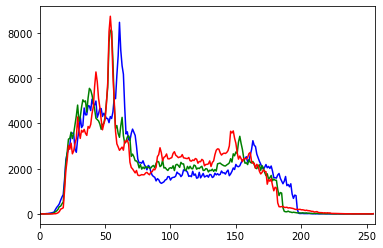

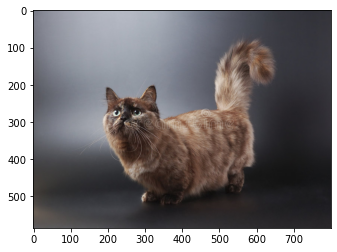

In [52]:
img_hist(train_files[4],train_targets[4])

In [31]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████| 484/484 [00:00<00:00, 489.30it/s]


## Using pre-trained VGG-19


In [32]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

def extract_VGG19(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_vgg19(tensors)
    return VGG19(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

#def extract_Resnet50(file_paths):
    #tensors = paths_to_tensor(file_paths).astype('float32')
    #preprocessed_input = preprocess_input_resnet50(tensors)
    #return ResNet50(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

Extracting the features may take a few minutes...

In [34]:
#train_vgg19 = "D:/Desktop/FYP/show-tell/static/CatIdentification/train_vgg19.pkl"
#valid_vgg19 = "D:/Desktop/FYP/show-tell/static/CatIdentification/valid_vgg19.pkl"
#test_vgg19 = "D:/Desktop/FYP/show-tell/static/CatIdentification/test_vgg19.pkl"

train_vgg19 = extract_VGG19(train_files)
valid_vgg19 = extract_VGG19(valid_files)
test_vgg19 = extract_VGG19(test_files)
print("VGG19 shape", train_vgg19.shape[1:])


100%|███████████████████████████████████████| 484/484 [00:01<00:00, 483.91it/s]


VGG19 shape (7, 7, 512)


For the second level model, [Batch Normalization](https://arxiv.org/abs/1502.03167) yet again proved to be very important. Without batch normalization the model will not reach 80% accuracy for 10 epochs. Dropout is also important as it allows for the model to train more epochs before starting to overfit. However a Dropout of 50% leads to a model that trains all 20 epochs without overfitting, yet does not reach 82% accuracy. I've found Dropout of 30% to be just right for the model below. Another important hyper parameter was the batch size. A bigger batch size leads to a model that learns faster, the accuracy increases very rapidly, but the maximum accuracy is a bit lower. A smaller batch size leads to a model that learns slower between epochs but reaches higher accuracy.

In [35]:
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers import Input, Dense
from keras.layers.core import Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import Sequential

### Define your architecture.
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=(train_vgg19.shape[1:])))
VGG19_model.add(Dense(134, activation='softmax'))

VGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 134)               68742     
Total params: 68,742
Trainable params: 68,742
Non-trainable params: 0
_________________________________________________________________


In [57]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model.
checkpointer_VGG19 = ModelCheckpoint(filepath='D:/Desktop/FYP/CatVgg19/Cat_Dataset/catvgg19epoch10.hdf5', verbose=1 , save_best_only =True)

hist = VGG19_model.fit(train_vgg19, train_targets,
                  validation_data = (valid_vgg19 ,valid_targets),
                  epochs=10, batch_size=20, callbacks=[checkpointer_VGG19], verbose=1)

Epoch 1/10
35/35 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9691 - val_loss: 8.2656 - val_accuracy: 0.3692

Epoch 00001: val_loss improved from inf to 8.26560, saving model to D:/Desktop/FYP/CatVgg19/Cat_Dataset\catvgg19epoch10.hdf5
Epoch 2/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9981 - val_loss: 8.5615 - val_accuracy: 0.3692

Epoch 00002: val_loss did not improve from 8.26560
Epoch 3/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 8.8586 - val_accuracy: 0.3231

Epoch 00003: val_loss did not improve from 8.26560
Epoch 4/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 8.5673 - val_accuracy: 0.3846

Epoch 00004: val_loss did not improve from 8.26560
Epoch 5/10
35/35 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9994 - val_loss: 8.9114 - val_accuracy: 0.3538

Epoch 00005: val_

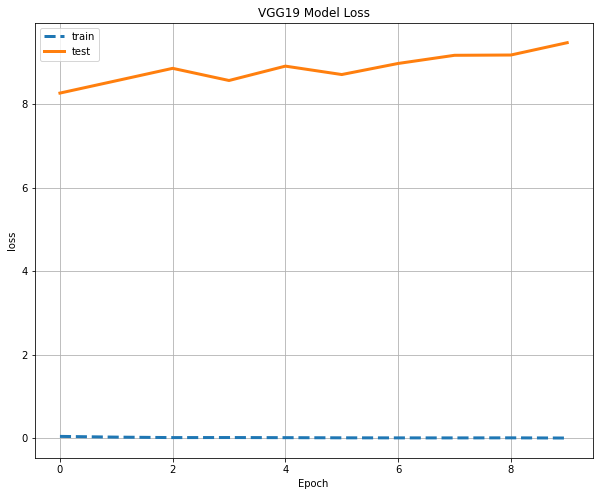

In [58]:
from matplotlib import pyplot as plt
## plot the history of loss and accuracy for train and valid data for the best model, Xception
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','test'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('VGG19 Model Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

tell/static/CatIdentification/Train\Norwegian_Forest_Cat


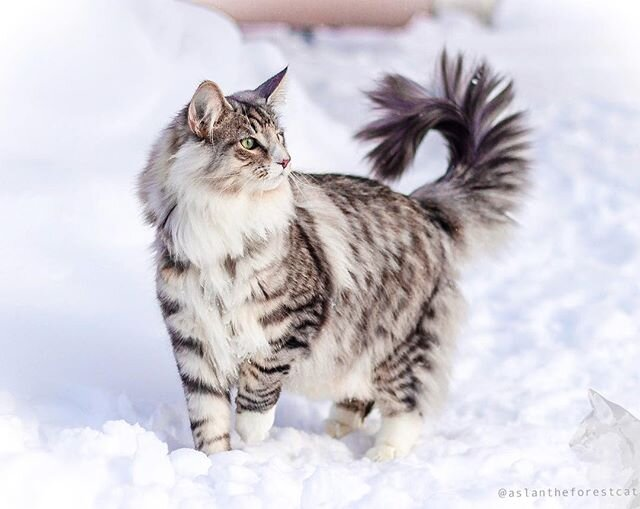

In [59]:
from tensorflow.keras.models import load_model, Model
from IPython.display import Image, display

#load the model
model = load_model('D:/Desktop/FYP/CatVgg19/Cat_Dataset/catvgg19epoch10.hdf5')
img_path = r'D:\Desktop\FYP\images\cat\nfc5.jpg'
x = path_to_tensor(img_path)
tensors = x.astype('float32')
preprocessed_input = preprocess_input_vgg19(tensors)
y = VGG19(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

predictions = model.predict([y])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
print(cat_names[breed_predictions[0]])
display(Image(filename = img_path, width = 600, height = 300))
